### DSCI 510 Final Project: Music Preferences During COVID-19
### 12/7/2020

**1.	Your name**

* Leon Luc

**2.	Any major “gotchas” to the code (i.e. things that don’t work, go slowly, could be improved, etc.)**
*  The Genius API takes about 30 minutes to complete because it is scraping song lyrics for approximately 500 songs via the Genius website.

**3.	Any libraries that need to be installed to run your code**

The following libraries need to be installed:
* bs4
* spotipy
* lyricsgenius
* nltk

This is not including common libraries such as pandas, numpy, matplotlib, etc.

Please view the **requirement.txt** file and use the command line to run **pip install -r requirements.txt** if any of these are not installed. Alternatively, you can manually install the four libraries one at a time.

**4.	Anything else you feel is relevant to the grading of your project.**
* My focus for this project was to create visualizations to investigate my research question as opposed to an conducting a statistical analysis or developing a machine learning model.
* The src folder is not included in the submission because I have no other python files invoked in this notebook.
* I use the words *song* and *track* interchangeably.

**5.	What did you set out to study?  (i.e. what was the point of your project?  This should be close to your Milestone 1 assignment, but if you switched gears or changed things, note it here.)**
* So much of our lives have changed due to the coronavirus pandemic. Knowing that more people have stayed at home, I wanted to look into people's music preferences during this time (03/28/2020 to 10/31/2020). Have people been choosing to stay upbeat by listening to pop or dance songs? Have people been dealing with the stress and anxiety by listening to slow or chill songs? Or is there any preference at all? Looking at a combination of audio features from Spotify and song lyrics from Genius, I hope to better understand what type of music has been popular during the pandemic.

**6.	What did you Discover/what were your conclusions (i.e. what were your findings?  Were your original assumptions confirmed, etc.?)**
* Hip hop and rap have dominated the Billboard Hot 100 charts during the pandemic. Led by Lil Uzi Vert, artists from these two genres have appealed to people who are looking for songs that evoke strong emotions through the song's audio and lyrics.
* My initial hypothesis for the kind of music that people have been listening to was that of sadness/depressing because  the pandemic has been tough on the world. Through my findings using the radar charts and stacked bar charts, I find my original thinking to be mostly confirmed.
* From the audio features in the radar charts, the top artists primarily have songs with less valence and high speechiness.
* From the song lyrics analysis in the stacked bar charts, the lyrics from all of the top artists, except for Taylor Swift, express greater negative lyrics than positive lyrics.
* I would say most people base their music tastes on what is being said, and so I am not surprised that genres that deliver strong messages like hip hop and rap have been big with listeners during the pandemic.

**7.	What difficulties did you have in completing the project?**
* As mentioned in Question 2, the Genius API took a lot of time to process. This made it a little difficult to test and debug the code during Milestone 2.
* I also had a some issues using pandas and matplotlib since I have not had much practice using them.

**8.	What skills did you wish you had while you were doing the project?**
* Referring to previous question, I wish I had more knowledge of pandas and matplotlib because I had to continuously look up how to do things that I wanted to implement.
* In general, having a higher level of understanding of doing data analysis with Python would have been beneficial.

**9.	What would you do “next” to expand or augment the project?** 
* I would try to use various classifiation algorithms to predict a song's genre/artist/rank based on its audio features and/or lyrics.
* In terms of getting more accurate results, I would want to get the precise genre for each song. I used the artist's overall genre as the value since it is not available for individual songs, which can be misleading for artists who have types of varied music.
* It would be interesting to see what preferences were like before and during the pandemic (and after once possible).

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#read in data from Milestone 2
#billboard_df = pd.read_csv(r"data/billboard_data.csv")
#unique_track = pd.read_csv(r"data/unique_track_data.csv")
#track_df = pd.read_csv(r"data/track_data.csv")
artist_df = pd.read_csv(r"data/artist_data.csv")
#lyric_df = pd.read_csv(r"data/lyric_data.csv")
combined_df = pd.read_csv(r"data/combined_data.csv")

#a few additional data cleaning steps
final_df = pd.merge(combined_df, artist_df.iloc[:,[0,3]], how="left", left_on="artist_id", right_on="artist_id")
final_df.loc[(final_df["artist_genre_group"] == '0'),"artist_genre_group"] = "n/a"
final_df["track_duration"] = final_df["track_duration"]/1000 #milliseconds -> seconds

#change blank lyrics to empty string
final_df.loc[(final_df["track_lyrics"].isnull()),"track_lyrics"] = ""

#make a dataframe to keep unique tracks
unique_track = final_df.drop_duplicates(subset=["song_id"])
unique_track = unique_track.reset_index(drop=True)

#### This first part will explore the data and answer basic questions:

* Which artists has the most songs in the Billboard Hot 100 from 3/28/2020 to 10/31/2020?

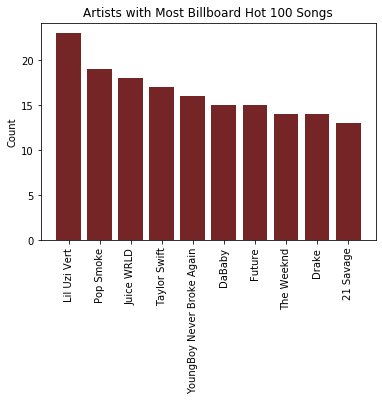

In [2]:
#get count of artists with most songs
most_songs = unique_track.groupby(["artist_name", "artist_genre_group"], as_index=False)["artist_id"].count().sort_values("artist_id", ascending=False).reset_index(drop=True)

plt.figure()
plt.bar(x=most_songs.loc[0:9,"artist_name"], height=most_songs.loc[0:9,"artist_id"], color=np.random.rand(3,))
plt.xticks(rotation=90) #names are long, so make vertical
plt.ylabel("Count")
plt.title("Artists with Most Billboard Hot 100 Songs")
plt.show()

Lil Uzi Vert has the most songs (23) in the Billboard Hot 100 during this time. Coming after him are Pop Smoke and Juice WRLD, who both passed away a few months before the pandemic hit the country. Taylor Swift is the only female artist in the top 10.

* Which genres make up the most popular songs?

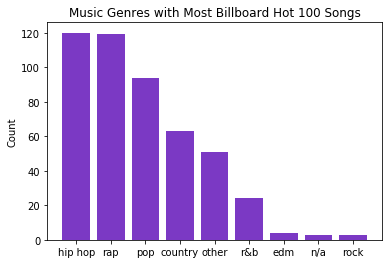

In [3]:
most_genre = unique_track.groupby(["artist_genre_group"], as_index=False)["song_id"].count().sort_values("song_id", ascending=False).reset_index(drop=True)

plt.figure()
plt.bar(x=most_genre.loc[:,"artist_genre_group"], height=most_genre.loc[:,"song_id"], color=np.random.rand(3,))
plt.ylabel("Count")
plt.title("Music Genres with Most Billboard Hot 100 Songs")
plt.show()

Hip hop (120) just edges out rap (119) for the most songs with pop coming in third. 

The margin that hip hop and rap has over pop makes me feel that people are preferring music based on rhythm and powerful statements over catchiness. My sense is that these songs will demonstrate less "valence," which is something that Spotify describes as "the musical positiveness conveyed by a track." I will explore this soon by looking at audio features.

* How long have songs been on the charts?

In [4]:
#get the max value for each track
most_chart_weeks = final_df.groupby(["song_name","artist_name"], as_index=False)["weeks_on_chart"].agg(np.max).sort_values("weeks_on_chart", ascending=False)
display(most_chart_weeks.head(10))

,song_name,artist_name,weeks_on_chart
81,Circles,Post Malone,60
377,Someone You Loved,Lewis Capaldi,54
402,The Bones,Maren Morris,52
115,Don't Start Now,Dua Lipa,51
54,Blinding Lights,The Weeknd,47
292,No Guidance,Chris Brown,46
8,Adore You,Harry Styles,46
34,Ballin',Mustard,44
199,I Hope,Gabby Barrett,43
193,Hot Girl Bummer,blackbear,42


Many of these songs have been on the Hot 100 for more than half a year. Circles by Post Malone has been there for longer than a year!

* Who has the most songs that peaked in the top 5?

In [5]:
#limit peak ranking to 1st-5th
peak_df = final_df[final_df["peak_rank"] <= 5] 
peak_df = peak_df.drop_duplicates(subset=["song_id"])

most_peaks = peak_df.groupby(["artist_name"], as_index=False)["artist_id"].agg({"num_of_tracks":np.size}).sort_values("num_of_tracks", ascending=False)
display(most_peaks.head(8))

,artist_name,num_of_tracks
20,Justin Bieber,3
36,Travis Scott,2
1,6ix9ine,2
21,Lady Gaga,2
11,Drake,2
19,Juice WRLD,2
33,Taylor Swift,2
34,The Weeknd,2


Justin Bieber has the most songs that peaked in the top 5, although none of them peaked at #1. Travis Scott and The Weeknd actually had their two songs on this list reach #1.

#### This next part will look into Spotify's audio features of songs and will focus on the top artists and genres identified in the previous bar graphs:

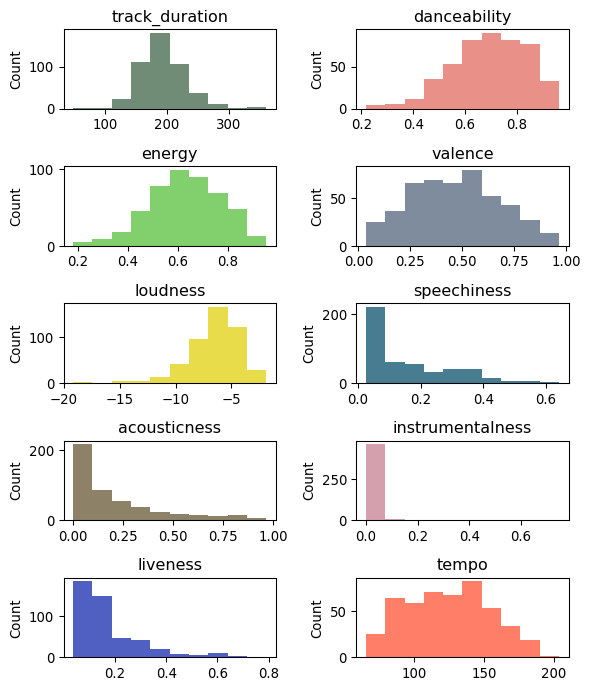

In [6]:
#the list of audio features
features = ["track_duration","danceability","energy","valence", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "tempo"]

#create a function to make the histograms
def histogram(data, nrow, ncol, index):
    #initiate plot
    plt.subplot(nrow, ncol, index+1)
    plt.tight_layout()
    plt.hist(unique_track[data][unique_track[data].notnull()], facecolor=np.random.rand(3,), alpha=0.75)
    
    #set labels and title
    plt.ylabel("Count")
    plt.title(data)

#set plot figure sizes
plt.figure(figsize=(600/96, 700/96), dpi=96)

for i in range(len(features)):
    histogram(data=features[i], nrow=5, ncol=2, index=i)

These histograms show the distribution of the various audio features.

In Spotify's API documentation, they include a histogram for each of these features based on its library. You can  check out the following: https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

When comparing the distributions, I see that the distribution above for energy is more normal compared to the documentation's, which is right-skewed. The valence distribution above is more normal and approaching left-skewed as well instead of uniform. This gives some insight into how songs during this time have been somewhat different from Spotify's library.

,artist_genre_group,track_duration,danceability,energy,valence,loudness,speechiness,acousticness,instrumentalness,liveness,tempo
0,country,200.039762,0.564556,0.694921,0.525889,-5.576079,0.041710,0.234306,0.002857,0.163841,120.872889
1,edm,175.124000,0.730750,0.707750,0.596250,-6.090000,0.107575,0.203150,0.000486,0.175875,125.004250
2,hip hop,189.312904,0.769470,0.631739,0.465265,-6.347678,0.221715,0.127192,0.009563,0.206952,126.285374
3,n/a,181.922000,0.770667,0.514333,0.407333,-7.230000,0.095667,0.087000,0.000003,0.207033,129.643667
4,other,190.636353,0.723333,0.673078,0.530627,-5.715843,0.192463,0.200717,0.000057,0.148633,129.775039
5,pop,203.661543,0.653957,0.568000,0.437428,-7.041330,0.082899,0.323187,0.009146,0.153323,118.259638
6,r&b,223.638913,0.578522,0.594565,0.314170,-7.683478,0.110109,0.175290,0.008430,0.182548,113.735652
7,rap,181.323043,0.724000,0.629155,0.460909,-6.690345,0.209859,0.164287,0.002920,0.188203,130.489103
8,rock,216.236333,0.774000,0.530333,0.752333,-7.772333,0.040500,0.134233,0.001477,0.109267,127.360333


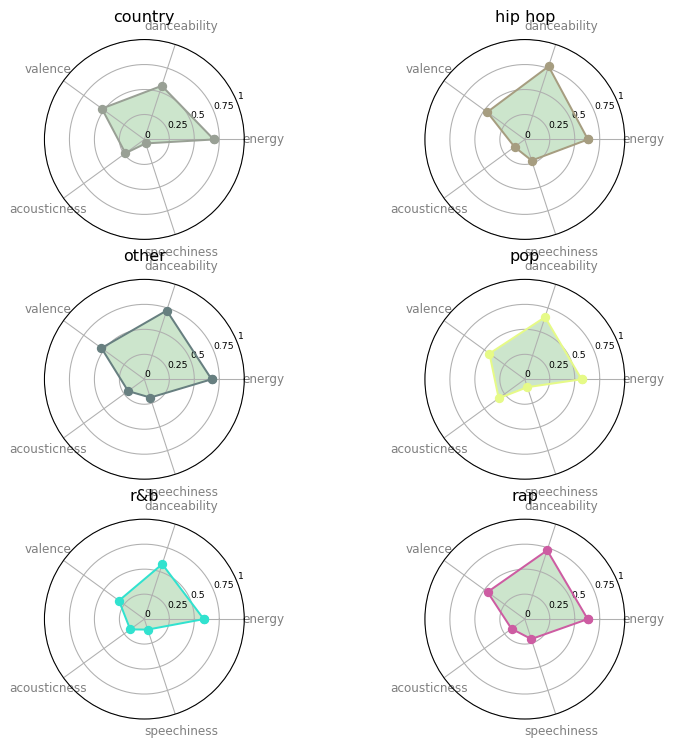

In [7]:
#create a function to make the radar charts
def radar_chart(data, nrow, ncol, index, title):
    df = pd.DataFrame({"feat": ["energy","danceability","valence","acousticness","speechiness"], "vals": [data.loc[index,"energy"],data.loc[index,"danceability"],data.loc[index,"valence"],data.loc[index,"acousticness"],data.loc[index,"speechiness"]]})
    
    #initiate plot
    ax = plt.subplot(nrow, ncol, index+1, polar=True)
    theta = np.arange(len(df) + 1) / float(len(df)) * 2 * np.pi
    vals = df["vals"].values
    vals = np.append(vals, vals[0])
    ax.plot(theta, vals, color=np.random.rand(3,), marker="o")
    ax.fill(theta, vals, "green", alpha=0.2)
    
    #set labels and title
    plt.xticks(theta[:-1], df["feat"], color='grey', size=9)
    plt.yticks([0,0.25,0.5,0.75,1], ["0","0.25","0.5","0.75","1"], color="black", size=7)
    plt.ylim(0,1)
    plt.title(f"{title}", size=12)

#get the average scores for the features and keep the ones to be studied
genre_list = ["hip hop", "rap", "pop", "country", "other", "r&b"]
genre_avg = unique_track.groupby(["artist_genre_group"], as_index=False)[features].mean()
top_genre = genre_avg[genre_avg["artist_genre_group"].isin(genre_list)].reset_index(drop=True)

#show table of scores
display(unique_track.groupby(["artist_genre_group"], as_index=False)[features].mean())

#plot all charts
plt.figure(figsize=(900/96, 900/96), dpi=96)
for i in range(len(genre_list)):
    radar_chart(data=top_genre, nrow=3, ncol=2, index=i, title=top_genre.loc[i,"artist_genre_group"])

The radar charts above display five audio features for the top 6 music genres. The values are based on the average for all of the songs in the specific genre.

I previously mentioned that I had a hunch that the valence would be low and it seems to me that this is sort of true. Note from the previous histogram that valence is more normal and close to left-skewed, which means that about half of these songs lean a little on the negative side when it comes to the audio. The energy scores are also centered around 0.6, and when you compare that to the Spotify documentation where most scores were 0.8, there is a clear difference in the intensity of these songs. The speechiness scores of hip hop and rap, although they do not look like much, also go with my thinking that people are tuning into the intense messaging of songs.

,artist_name,track_duration,danceability,energy,valence,loudness,speechiness,acousticness,instrumentalness,liveness,tempo
0,DaBaby,159.217000,0.825083,0.648250,0.692667,-5.955750,0.306583,0.113605,0.000000e+00,0.180592,126.586583
1,Future,191.768533,0.818200,0.577133,0.458600,-7.395067,0.251387,0.093626,1.383133e-04,0.160773,140.940533
2,Juice WRLD,181.569176,0.654059,0.615176,0.369318,-6.457588,0.098935,0.187141,4.800000e-06,0.160729,132.555941
3,Lil Uzi Vert,196.309000,0.811217,0.636565,0.482826,-6.135304,0.264409,0.093974,3.308696e-07,0.234339,138.343174
4,Pop Smoke,179.101158,0.699211,0.640368,0.486211,-6.547474,0.233289,0.224397,2.924737e-05,0.179232,125.311474
5,Taylor Swift,235.703176,0.580176,0.438765,0.396059,-9.949647,0.041229,0.673512,1.985453e-04,0.111300,115.789353
6,The Weeknd,241.255286,0.501286,0.640500,0.250564,-7.085929,0.068607,0.122286,1.183247e-02,0.193564,121.552929
7,YoungBoy Never Broke Again,170.614733,0.671400,0.714400,0.614200,-5.315667,0.308387,0.234873,0.000000e+00,0.208780,130.793867


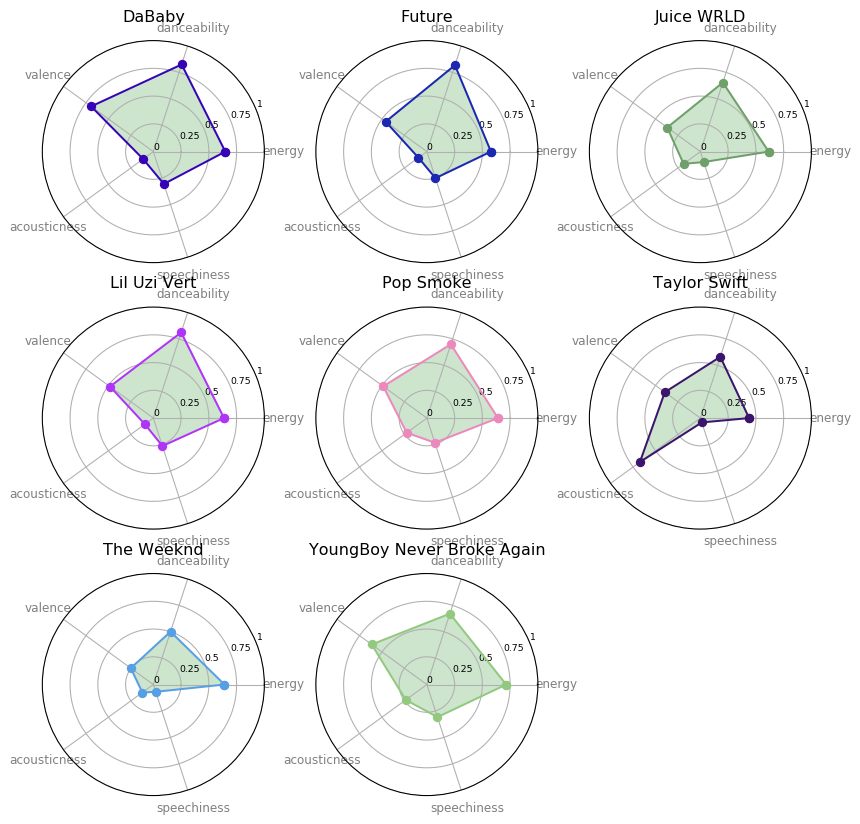

In [8]:
artist_avg = unique_track.groupby(["artist_name"], as_index=False)[features].mean()
artist_list = ["Lil Uzi Vert", "Pop Smoke", "Juice WRLD", "Taylor Swift", "YoungBoy Never Broke Again", "DaBaby", "Future", "The Weeknd"]
top_artist = artist_avg[artist_avg["artist_name"].isin(artist_list)].reset_index(drop=True)

display(artist_avg[artist_avg["artist_name"].isin(artist_list)].reset_index(drop=True))

plt.figure(figsize=(1000/96, 1000/96), dpi=96)
for i in range(0, 8):
    radar_chart(data = top_artist, nrow=3, ncol=3, index=i, title=top_artist.loc[i,"artist_name"])

In looking at the audio features by top artists, I see two main groups where one group (Pop Smoke, Juice WRLD, The Weeknd...even Taylor Swift)) has less valence and another group (Lil Uzi Vert, DaBaby, YoungBoy Never Broke Again) has greater danceability and energy. This illustrates how hip hop and rap are versatile genres in that they can elicit both cheerful/upbeat and depressed/angry sound qualities. With this in mind, I am thinking that the lyrics are the driving force behind these music choices.

#### This last part will look at song lyrics from Genius:

In [9]:
#convert song lyrics into list of words and sentences for lyric analysis
unique_track["track_lyrics_words"] = ""
unique_track["track_lyrics_sentence"] = ""
for i in range(len(unique_track)):
    unique_track.at[i,"track_lyrics_words"] = [word for word in unique_track.at[i,"track_lyrics"].split() if word != ""]
    unique_track.at[i,"track_lyrics_sentence"] = [sentence for sentence in unique_track.at[i,"track_lyrics"].split("\n") if sentence != ""]

#find how many words in each song
for i in range(len(unique_track)):
    unique_track.at[i,"track_words"] = len(unique_track.loc[i,"track_lyrics_words"])

#show top 10 most wordy artists
most_words = unique_track.groupby(["artist_name","artist_genre_group"], as_index=False)["track_words"].agg({"track_words": np.mean, "num_of_tracks": np.size}).sort_values("track_words", ascending=False).reset_index(drop=True)
display(most_words[most_words["num_of_tracks"] >= 5].head(10))

,artist_name,artist_genre_group,track_words,num_of_tracks
8,Lil Baby,hip hop,719.000000,11.0
14,Lil Uzi Vert,rap,638.130435,23.0
20,DaBaby,hip hop,596.266667,15.0
29,Polo G,rap,557.909091,11.0
30,YoungBoy Never Broke Again,rap,554.687500,16.0
31,Big Sean,hip hop,550.200000,5.0
33,Gunna,hip hop,531.083333,12.0
34,Megan Thee Stallion,rap,530.800000,5.0
35,Future,hip hop,530.466667,15.0
39,Drake,hip hop,514.000000,14.0


Hip hop and rap artists dominate the word count, although they tend to use plenty of ad-libs. Megan Thee Stallion is the only female in the top 10.

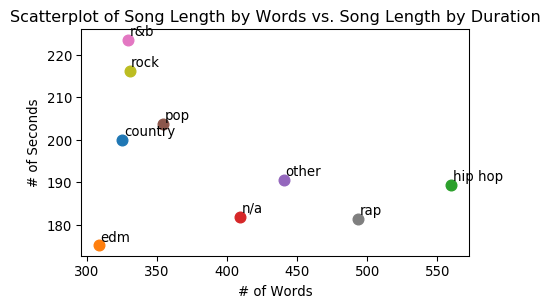

In [10]:
#get average song word count and duration by genre
words_and_duration = unique_track.groupby(["artist_genre_group"], as_index=False)[["track_words","track_duration"]].agg([np.mean,np.size])

#create scatterplot for words vs duration
plt.figure(figsize=(500/96, 300/96), dpi=96)
for i in range(len(words_and_duration)):
    #initiate plot
    plt.plot(words_and_duration["track_words"]["mean"][i], words_and_duration["track_duration"]["mean"][i], "o", ms=8)
    
    #set labels and title
    plt.text(x=words_and_duration["track_words"]["mean"][i]+1, y=words_and_duration["track_duration"]["mean"][i]+1, s=words_and_duration.index[i], fontsize=10)
    plt.xlabel("# of Words")
    plt.ylabel("# of Seconds")
    plt.title("Scatterplot of Song Length by Words vs. Song Length by Duration")

The results of this scatterplot are pretty interesting. Hip hop and rap have much more words compared to country and r&b, yet these genres are among the shortest. There appears to be a negative correlation between word count and duration.

In [11]:
#get correlation
words_and_duration["track_words"]["mean"].corr(words_and_duration["track_duration"]["mean"])

-0.4236163947509014

Calculating the correlation between word length and duration shows that there is indeed a negative linear relationship between the two.

In [12]:
#make master list of words from all songs
all_words = []
for i in range(len(unique_track)):
    all_words.extend(unique_track.at[i,"track_lyrics_words"])

#find frequency of all of these words
word_dict = {}
for i in all_words:
    word_dict[i] = word_dict.get(i,0) + 1

for word in sorted(word_dict, key=word_dict.get, reverse=True)[:10]:
    print(f"\"{word}\" appears {word_dict[word]} times.")

"I" appears 8864 times.
"the" appears 6568 times.
"you" appears 4797 times.
"a" appears 4732 times.
"my" appears 3400 times.
"to" appears 3269 times.
"me" appears 2910 times.
"I'm" appears 2831 times.
"in" appears 2793 times.
"it" appears 2389 times.


The above shows the top 10 most frequent words used in all of the songs. This would be more compelling if the "common" words were eliminated, but it is still interesting to see that *I* is at the top.

In [13]:
#create columns for each sentiment score
unique_track["neg_rate"] = ""
unique_track["neut_rate"] = ""
unique_track["pos_rate"] = ""

#Vader sentiment analyzer
sid = SentimentIntensityAnalyzer()
for i in range(len(unique_track)):
    neg_score = 0
    neut_score = 0
    pos_score = 0
    if len(unique_track.loc[i,'track_lyrics_sentence']) > 0: #the song has lyrics in the data
        for sentence in range(len(unique_track.loc[i,'track_lyrics_sentence'])):
            #calculating the score for each sentence (line) in the song
            comp = sid.polarity_scores(unique_track.loc[i,'track_lyrics_sentence'][sentence])['compound']
            #classiying sentence as positive, negative, or neutral based on what compound score is
            if comp >= 0.5:
                pos_score += 1
            elif comp > -0.5 and comp < 0.5:
                neut_score += 1
            else: # <= 0.5
                neg_score += 1
        #get each rate by dividing by total scores
        total = float(neg_score + neut_score + pos_score)
        unique_track.at[i,"neg_rate"] = (neg_score/total)*100
        unique_track.at[i,"neut_rate"] = (neut_score/total)*100
        unique_track.at[i,"pos_rate"] = (pos_score/total)*100
    else:
        continue

#convert to numeric type
unique_track["neg_rate"] = unique_track["neg_rate"].apply(pd.to_numeric)
unique_track["neut_rate"] = unique_track["neut_rate"].apply(pd.to_numeric)
unique_track["pos_rate"] = unique_track["pos_rate"].apply(pd.to_numeric)

In the above code, I am using the Vader Sentiment analyzer from the NLTK package to give scores to the song lyrics. Each lyric sentence is given a positive, negative, or neutral score and then an overall score is given to the song.

,neg_rate,neut_rate,pos_rate
,mean,mean,mean
artist_genre_group,,,
hip hop,12.991926,80.140901,6.867173
rap,14.351393,76.709128,8.939480
pop,7.097659,81.564217,11.338124
country,2.844219,85.236538,11.919243
other,9.998888,82.815154,7.185958
r&b,8.681186,85.514589,5.804225


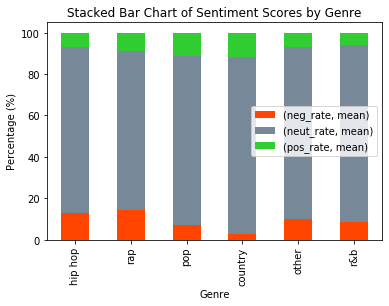

In [14]:
#summarize the 3 sentiment rates by genre
track_scores = unique_track.groupby(["artist_genre_group"], as_index=False)[["neg_rate","neut_rate","pos_rate"]].agg([np.mean])

display(track_scores.loc[genre_list])

#create stacked bar chart
track_scores.loc[genre_list].plot.bar(stacked=True, color=["orangered","lightslategrey","limegreen"])
plt.xlabel("Genre")
plt.ylabel("Percentage (%)")
plt.title("Stacked Bar Chart of Sentiment Scores by Genre")
plt.legend(loc=5)
plt.show()

Based on the stacked bar chart and table above, hip hop and rap, on average, exhibit the most negative lyrics while pop and country are the most positive. From the radar charts earlier, these two genres had the largest *speechiness* scores and my hunch was that people would resonate  strongly with the lyrics. It seems that from looking at both the audio features and lyrics, hip hop and rap emanate feelings that are more on the negative side.

,,neg_rate,neut_rate,pos_rate
,,mean,mean,mean
artist_name,artist_genre_group,,,
DaBaby,hip hop,17.663144,76.556215,5.780641
Future,hip hop,11.730460,82.318627,5.950913
Juice WRLD,rap,12.276564,76.906466,10.816970
Lil Uzi Vert,rap,12.119839,82.385833,5.494328
Pop Smoke,other,11.159196,79.030844,9.809960
Taylor Swift,pop,7.141247,85.470071,7.388682
The Weeknd,r&b,10.506810,83.719717,5.773473
YoungBoy Never Broke Again,rap,18.143530,77.336047,4.520423


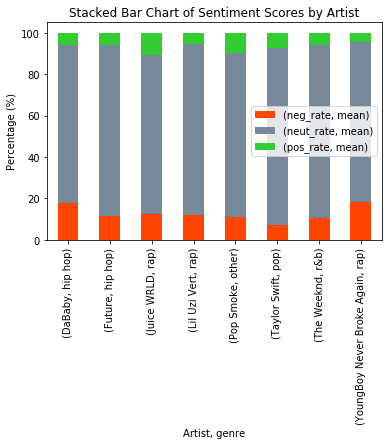

In [15]:
#same as before but by artist
track_scores = unique_track.groupby(["artist_name","artist_genre_group"], as_index=False)[["neg_rate","neut_rate","pos_rate"]].agg([np.mean])
track_scores.loc[artist_list].plot.bar(stacked=True, color=["orangered","lightslategrey","limegreen"])

display(track_scores.loc[artist_list])

plt.xlabel("Artist, genre")
plt.ylabel("Percentage (%)")
plt.title("Stacked Bar Chart of Sentiment Scores by Artist" )
plt.legend(loc=5)
plt.show()

Previously, I grouped a few artists together based on their radar charts (i.e. Pop Smoke/Juice WRLD vs. Lil Uzi Vert/DaBaby). It is interesting that the first group I identified as having less valence has greater positive lyrics than the second group, which typically had greater danceability and energy. Seeing DaBaby have one of the most negative lyrics yet have one of the highest danceability tells me that audio features and song lyrics may not go hand-in-hand. 

As an example, Pop Smoke and Juice WRLD made songs about their hardships in which they crafted their music to sound more dark and nihilistic, but showcased passion and determination in their lyrics.